In [1]:
using Pkg
Pkg.activate("/home/claudio/postdoc/ACE.jl/Project.toml")

using LinearAlgebra, Statistics, Random, ProgressMeter, ScikitLearn, PyPlot
using ACE: alloc_B, alloc_temp, evaluate!,alloc_dB, alloc_temp_d, evaluate_d!, rpi_basis, rnn
using NeighbourLists: maxneigs
using JuLIP: sites, neighbourlist, cutoff, JVec, AbstractAtoms, fltype, AtomicNumber
using JuLIP.Potentials: neigsz!
using JuLIP.MLIPs: combine
using IPFitting.Data: read_xyz
using Einsum
@sk_import linear_model: Ridge
using ScikitLearn.CrossValidation: train_test_split

 Activating environment at `~/postdoc/ACE.jl/Project.toml`
┌ Info: Precompiling IPFitting [3002bd4c-79e4-52ce-b924-91256dde4e52]
└ @ Base loading.jl:1278
┌ Info: Skipping precompilation since __precompile__(false). Importing IPFitting [3002bd4c-79e4-52ce-b924-91256dde4e52].
└ @ Base loading.jl:1034
┌ Info: Precompiling ASE [51974c44-a7ed-5088-b8be-3e78c8ba416c]
└ @ Base loading.jl:1278
┌ Info: Skipping precompilation since __precompile__(false). Importing ASE [51974c44-a7ed-5088-b8be-3e78c8ba416c].
└ @ Base loading.jl:1034


extract_info_frame (generic function with 1 method)

In [16]:
# Data loading

all_traj = read_xyz("/home/claudio/postdoc/integrated_potentials/data/Si_2018/delta_silicon.xyz", 
    energy_key="dft_energy", force_key="dft_force", verbose=false);


# Data parsing

types = ["bcc","fcc","hcp","bt","liq","amorph","dia"]
traj = Any[]
for tt in all_traj
   if tt.configtype in types
        push!(traj, tt)
    end
end

┌ Info: Keys used: E => "dft_energy", F => "dft_force", V => "dft_virial"
└ @ IPFitting.Data /home/claudio/.julia/packages/IPFitting/Ypo4v/src/data.jl:153
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


┌─────────────────────┬───────┬────────┬───────┬────────┬───────┐
│         config_type │ #cfgs │  #envs │    #E │     #F │    #V │
│              String │ Int64 │  Int64 │ Int64 │  Int64 │ Int64 │
├─────────────────────┼───────┼────────┼───────┼────────┼───────┤
│       isolated_atom │     1 │      1 │     1 │      3 │     0 │
│                  sh │   223 │   4552 │   223 │  13656 │  1467 │
│                 dia │   489 │  16708 │   489 │  50124 │  4401 │
│                  bt │   445 │  16620 │   445 │  49860 │  4005 │
│                 liq │    76 │   5312 │    76 │  15936 │   630 │
│              amorph │   159 │  29632 │   159 │  88896 │     0 │
│         surface_001 │    29 │   4176 │    29 │  12528 │     0 │
│         surface_110 │    26 │   2808 │    26 │   8424 │     0 │
│         surface_111 │    47 │   4512 │    47 │  13536 │     0 │
│  surface_111_pandey │    50 │   4800 │    50 │  14400 │     0 │
│      crack_110_1-10 │     7 │   1400 │     7 │   4200 │    63 │
│      cra

In [17]:
# Descriptor parameters

N = 8               # Body order
maxdeg = 10         # Number of basis (?)
rcut = 5.0          # Radial Cutoff
species = :Si;      # Well... Species
r0 = 1.0            # Lowest radius for basis
reg = 1e-8;         # Ridge regularizer

basis = rpi_basis(; species=species, N = N, r0 = r0,
   maxdeg = maxdeg, rcut = rcut,
   rin = rnn(:Si) * 0.6,
   constants = false);

In [56]:

# Local : environment descriptor
function environment_descriptor(shipB, at::AbstractAtoms{T}) where {T}
    E = zeros(fltype(shipB), length(at), length(shipB))
    B = alloc_B(shipB)
    nlist = neighbourlist(at, cutoff(shipB))
    maxnR = maxneigs(nlist)
    tmp = alloc_temp(shipB, maxnR)
    tmpRZ = (R = zeros(JVec{T}, maxnR), Z = zeros(AtomicNumber, maxnR))
    for i = 1:length(at)
        j, R, Z = neigsz!(tmpRZ, nlist, at, i)
        fill!(B, 0)
        evaluate!(B, tmp, shipB, R, Z, at.Z[i])
        E[i,:] = B[:]
    end
    return E
end

# Local : environments for all the atoms in trajectory
function environment_descriptor_traj(basis, traj)
    A_all = []
    for i in 1:length(traj)
        atoms = traj[i].at
        X = environment_descriptor(basis, atoms);
        push!(A_all, X)
    end
    return A_all
end;


# Global : sum descriptor
function sum_descriptor(shipB, at::AbstractAtoms{T}) where {T}
    E = zeros(fltype(shipB), length(shipB))
    B = alloc_B(shipB)
    nlist = neighbourlist(at, cutoff(shipB))
    maxnR = maxneigs(nlist)
    tmp = alloc_temp(shipB, maxnR)
    tmpRZ = (R = zeros(JVec{T}, maxnR), Z = zeros(AtomicNumber, maxnR))
    for i = 1:length(at)
        j, R, Z = neigsz!(tmpRZ, nlist, at, i)
        fill!(B, 0)
        evaluate!(B, tmp, shipB, R, Z, at.Z[i])
        E[:] .+= B[:]
    end
    return E
end

function sum_descriptor_traj(basis, traj)
    A_all = Array{Float64,2}(undef, length(traj), length(basis)) 
    for i in 1:length(traj)
        atoms = traj[i].at
        A_all[i, :] = sum_descriptor(basis, atoms)
    end
    return A_all
end

function sum_d_descriptor(shipB, at::AbstractAtoms{T}) where {T}
   # precompute the neighbourlist to count the number of neighbours
    nlist = neighbourlist(at, cutoff(shipB); storelist=false)
    maxR = maxneigs(nlist)
   # allocate space accordingly
    F = zeros(JVec{T}, length(at), length(shipB))
    F_local = zeros(JVec{T}, length(at), length(at), length(shipB))
    B = alloc_B(shipB, maxR)
    dB = alloc_dB(shipB, maxR)
    tmp = alloc_temp_d(shipB, maxR)
    tmpRZ = (R = zeros(JVec{T}, maxR), Z = zeros(AtomicNumber, maxR))
    return sum_d_descriptor_inner!(shipB, at, nlist, F, F_local, B, dB, tmp, tmpRZ)
end

# this is a little hack to remove a type instability. It probably makes no
# difference in practise...
function sum_d_descriptor_inner!(shipB, at::AbstractAtoms{T},
                       nlist, F, F_local, B, dB, tmp, tmpRZ) where {T}
   # assemble site gradients and write into F
    for i = 1:length(at)
        j, R, Z = neigsz!(tmpRZ, nlist, at, i)
        fill!(dB, zero(JVec{T}))
        fill!(B, 0)
        evaluate_d!(B, dB, tmp, shipB, R, Z, at.Z[i])
        for a = 1:length(R)
            F[j[a], :] .-= dB[:, a]
            F[i, :] .+= dB[:, a]
            F_local[i, j[a], :] .-= dB[:, a]
        end
    end
    virial = compute_virial(F_local, at)
    return [ F[:, iB] for iB = 1:length(shipB) ], [virial[:, :, iB] for iB = 1:length(shipB) ]
end

function sum_d_descriptor_traj(basis, traj)
    dA_all = []
    dA_ds = []
    for i in 1:length(traj)
        atoms = traj[i].at
        XF, virial = sum_d_descriptor(basis, atoms);
        XF = hcat([collect(Iterators.flatten(a)) for a in XF]...)
        push!(dA_all, XF)
        push!(dA_ds, virial)
    end
    return dA_all, dA_ds
end

function fit_potential(XE_tr, YE_tr, XF_tr, YF_tr, alpha=1.0)
    YF_tr = hcat(YF_tr'...)'
    XF_tr = hcat(XF_tr'...)'
    X_tr = vcat(XE_tr, XF_tr)
    Y_tr = vcat(YE_tr, YF_tr);
    ridge_pred = fit!(Ridge(alpha), X_tr, Y_tr)
    return ridge_pred
end

function predict_potential(ridge_pred, XE_tst, XF_tst)
    n_struc = length(XE_tst[:, 1])
    XF_tst = hcat(XF_tst'...)'
    X_tst = vcat(XE_tst, XF_tst)
    result = predict(ridge_pred, X_tst)
    return result[1:n_struc], result[n_struc + 1:end]
end

function extract_info_traj(B, traj)
    X = sum_descriptor_traj(B, traj);
    dX_dr, dX_ds = sum_d_descriptor_traj(B, traj);
    
    return X, dX_dr, dX_ds
end

function extract_info_frame(B, frame)
    X = sum_descriptor(B, frame);
    dX_dr, dX_dr_local = sum_d_descriptor(B, frame);
    
    return X, dX_dr, dX_dr_local
end

function compute_virial(F_local, at)
    p = [tup[k] for tup in at.X, k in 1:3]
    d = permutedims(repeat(p[:, :], 1, 1, length(at.X)) .- permutedims(repeat(p[:, :], 1, 1, length(at.X)), (3, 2, 1)), (1, 3, 2))
    F_local = [tup[k] for tup in F_local, k in 1:3]
    @einsum v[c1, c2, s] :=  - F_local[n, m, s, c1] * d[n, m, c2]
    return v
    end;

In [58]:
# Generate descriptors and extract data

X, dX_dr, dX_ds = extract_info_traj(basis, all_traj[1:10])

# XE_tr, XE_tst, YE_tr, YE_tst, XF_tr, XF_tst, YF_tr, YF_tst, nat_tr, nat_tst = train_test_split(
#     XE, YE, XF, YF, nat, test_size=0.25, random_state=42);

(10,)(210,)

In [6]:
# Fit and Predict
factor = 1.5
reg = 1.2e-6
factor = 0.123
reg =  0.0007

rr = fit_potential(XE_tr, YE_tr, XF_tr.*factor, YF_tr.*factor,reg)
e_hat, f_hat = predict_potential(rr, XE_tst, XF_tst.*factor)

rmse_e = mean((YE_tst./nat_tst .-  e_hat./nat_tst).^2).^0.5
print("RMSE Energy [meV/atom]: ", 1000*rmse_e)

rmse_f = mean((hcat(YF_tst'...)' .-  f_hat./factor).^2).^0.5
print("\nRMSE Forces [eV/A]:     ", rmse_f)

RMSE Energy [meV/atom]: 39.6777373566608
RMSE Forces [eV/A]:     0.3216668252460817

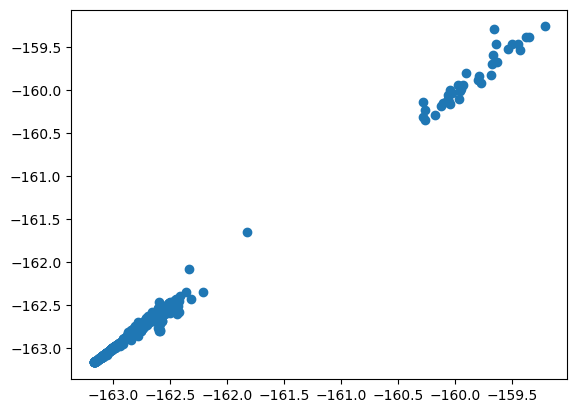

PyObject <matplotlib.collections.PathCollection object at 0x7fbe800b5d90>

In [7]:
scatter(YE_tst./nat_tst,   e_hat./nat_tst)

In [8]:
using IPFitting: LsqDB, lsqfit, rmse_table
using ACE: OneBody

dB = LsqDB(basis, all_traj, ones(1, 1), "E")
weights = Dict("default" => Dict("E" => 15.0, "F" => 1.0 ))
Vref = OneBody(Dict("Si" => -158.54496821))
IP, lsqinfo = lsqfit(dB; weights = weights, Vref = Vref, asmerrs = true, solver=(:lap, 1.2));

┌ Info: assemble lsq system
└ @ IPFitting.Lsq /home/claudio/.julia/packages/IPFitting/Ypo4v/src/lsq.jl:390
┌ Info: Free Memory: ≈ 8.42 GB
└ @ IPFitting.Lsq /home/claudio/.julia/packages/IPFitting/Ypo4v/src/lsq.jl:314


LoadError: KeyError: key "E" not found

In [9]:
for i in dB.configs
    a = i.D["E"]
    b = i.D["F"]
end

In [10]:
using IPFitting: observations
using IPFitting.DB: matrows
for (obskey, dat, icfg) in observations(dB)  # obskey ∈ {"E","F",...}; d::Dat
    print(dat, "\n")
    print(obskey, "\n")
    print(icfg, "\n")
    print("\n \n \n \n")
    irows = matrows(dat, obskey)
end

IPFitting.Dat(JuLIP.Atoms{Float64}(StaticArrays.SArray{Tuple{3},Float64,1,3}[[10.0, 10.0, 10.0]], StaticArrays.SArray{Tuple{3},Float64,1,3}[[0.0, 0.0, 0.0]], [28.085], AtomicNumber[<14>], [20.0 0.0 0.0; 0.0 20.0 0.0; 0.0 0.0 20.0], Bool[1, 1, 1], nothing, JuLIP.DofManager{Float64}(false, [1, 2, 3], JuLIP.LinearConstraint{Float64}[], StaticArrays.SArray{Tuple{3},Float64,1,3}[], [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]), Dict{Any,JuLIP.JData{Float64}}("nlist:default" => JuLIP.JData{Float64}(0.0, 0.0, NeighbourLists.PairList{Float64,Int64}(StaticArrays.SArray{Tuple{3},Float64,1,3}[[10.0, 10.0, 10.0]], [20.0 0.0 0.0; 0.0 20.0 0.0; 0.0 0.0 20.0], 5.0, Int64[], Int64[], StaticArrays.SArray{Tuple{3},Int64,1,3}[], [1, 1])))), "isolated_atom", Dict("E" => [-158.54496821],"F" => [0.0, 0.0, 0.0]), Dict{String,Array{Int64,1}}(), Dict{String,Any}())
E
1

 
 
 


LoadError: KeyError: key "E" not found

In [100]:
matrows()

LoadError: MethodError: no method matching matrows()
Closest candidates are:
  matrows(!Matched::IPFitting.Dat, !Matched::String) at /home/claudio/.julia/packages/IPFitting/Ypo4v/src/lsq_db.jl:235

In [88]:
rmse_table(lsqinfo["errors"])

LoadError: UndefVarError: lsqinfo not defined

In [ ]:
using Optim: optimize

function test_error(XE_tr, YE_tr, XF_tr, YF_tr, XE_tst, XF_tst, YE_tst, nat_tst, regs)
    print(regs, "\n")
    rr = fit_potential(XE_tr, YE_tr, XF_tr.*regs[2], YF_tr.*regs[2], regs[1])
    e_hat, f_hat = predict_potential(rr, XE_tst, XF_tst.*regs[2])
    rmse_e = mean((YE_tst./nat_tst .-  e_hat./nat_tst).^2).^0.5
    return rmse_e
end

res = optimize(regs -> test_error(XE_tr, YE_tr, XF_tr, YF_tr, XE_tst, XF_tst, YE_tst, nat_tst, regs), [1.2e-7, 1.5])